### Supplementary Notebook 3D
---
### Seurat [(Stuart et al., 2019)](https://doi.org/10.1016/j.cell.2019.05.031) analysis performed on the 10x PBMC scATAC-seq dataset 

The processed result of this datasest is shown in **Figure 3D** of the manuscript.

**Publication**: [Comprehensive Integration of Single-Cell Data](https://www.cell.com/cell/fulltext/S0092-8674(19)30559-8) 

**Data**: [link](https://support.10xgenomics.com/single-cell-multiome-atac-gex/datasets/1.0.0/pbmc_granulocyte_sorted_10k)

In [1]:
options(warn=-1)
library(Seurat)
library(ggplot2)
library(patchwork)

In [2]:
peaks <- Read10X_h5('atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5')

In [3]:
activity.matrix <- CreateGeneActivityMatrix(peak.matrix = peaks, 
    annotation.file = '/data/pinello/COMMON_DATA/Homo_sapiens.GRCh37.87.gtf', 
    seq.levels = c(1:22, "X", "Y"), upstream = 2000, verbose = TRUE)

In [4]:
pbmc.atac <- CreateSeuratObject(counts = peaks, assay = "ATAC", project = "10x_ATAC")
pbmc.atac[["ACTIVITY"]] <- CreateAssayObject(counts = activity.matrix)
meta <- read.table("atac_v1_pbmc_10k_singlecell.csv", sep = ",", header = TRUE, row.names = 1, 
    stringsAsFactors = FALSE)
meta <- meta[colnames(pbmc.atac), ]
pbmc.atac <- AddMetaData(pbmc.atac, metadata = meta)
pbmc.atac <- subset(pbmc.atac, subset = nCount_ATAC > 5000)
pbmc.atac$tech <- "atac"

In [5]:
DefaultAssay(pbmc.atac) <- "ACTIVITY"
pbmc.atac <- FindVariableFeatures(pbmc.atac)
pbmc.atac <- NormalizeData(pbmc.atac)
pbmc.atac <- ScaleData(pbmc.atac)

Centering and scaling data matrix



In [6]:
DefaultAssay(pbmc.atac) <- "ATAC"
VariableFeatures(pbmc.atac) <- names(which(Matrix::rowSums(pbmc.atac) > 100))
pbmc.atac <- RunLSI(pbmc.atac, n = 50, scale.max = NULL)
pbmc.atac <- RunUMAP(pbmc.atac, reduction = "lsi", dims = 1:50, n.components = 3)

Performing TF-IDF normalization

Running SVD on TF-IDF matrix

Scaling cell embeddings

01:39:10 UMAP embedding parameters a = 0.9922 b = 1.112

01:39:10 Read 7866 rows and found 50 numeric columns

01:39:10 Using Annoy for neighbor search, n_neighbors = 30

01:39:10 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

01:39:12 Writing NN index file to temp file /tmp/Rtmp3Pu1WT/file1deb5d7f2de0

01:39:12 Searching Annoy index using 1 thread, search_k = 3000

01:39:14 Annoy recall = 100%

01:39:16 Commencing smooth kNN distance calibration using 1 thread

01:39:17 Initializing from normalized Laplacian + noise

01:39:18 Commencing optimization for 500 epochs, with 300642 positive edges

01:39:39 Optimization finished



In [7]:
pbmc.rna <- readRDS("./pbmc_10k_v3.rds")
pbmc.rna$tech <- "rna"

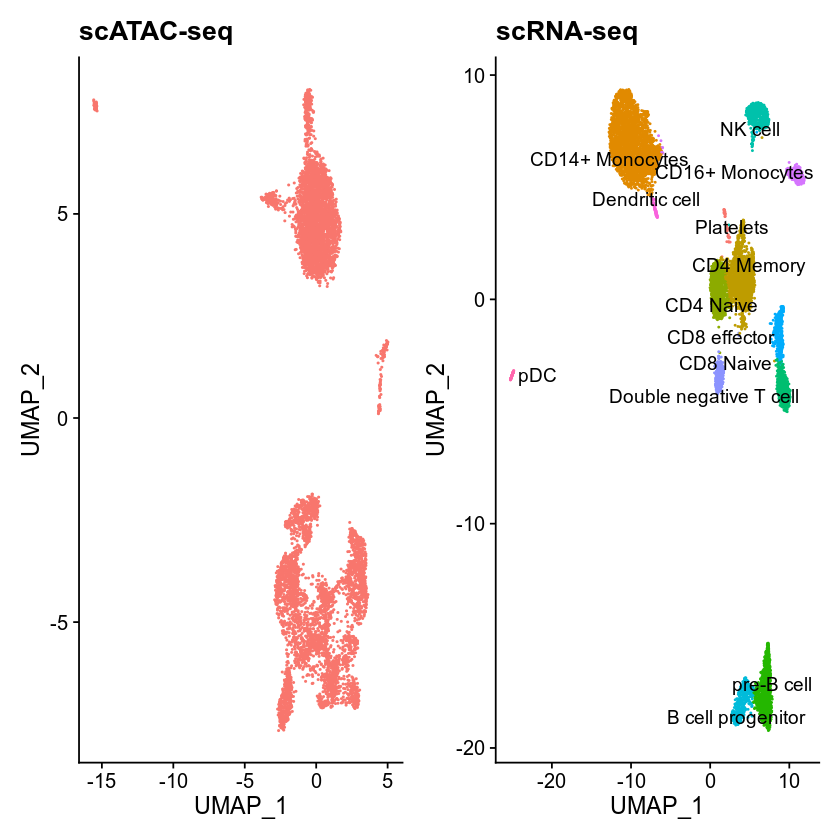

In [8]:
p1 <- DimPlot(pbmc.atac, reduction = "umap") + NoLegend() + ggtitle("scATAC-seq")
p2 <- DimPlot(pbmc.rna, group.by = "celltype", label = TRUE, repel = TRUE) + NoLegend() + ggtitle("scRNA-seq")
p1 + p2

In [9]:
transfer.anchors <- FindTransferAnchors(reference = pbmc.rna, query = pbmc.atac, features = VariableFeatures(object = pbmc.rna), 
    reference.assay = "RNA", query.assay = "ACTIVITY", reduction = "cca")

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 18712 anchors

Filtering anchors

	Retained 3453 anchors



In [10]:
celltype.predictions <- TransferData(anchorset = transfer.anchors, refdata = pbmc.rna$celltype, 
    weight.reduction = pbmc.atac[["lsi"]])
pbmc.atac <- AddMetaData(pbmc.atac, metadata = celltype.predictions)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



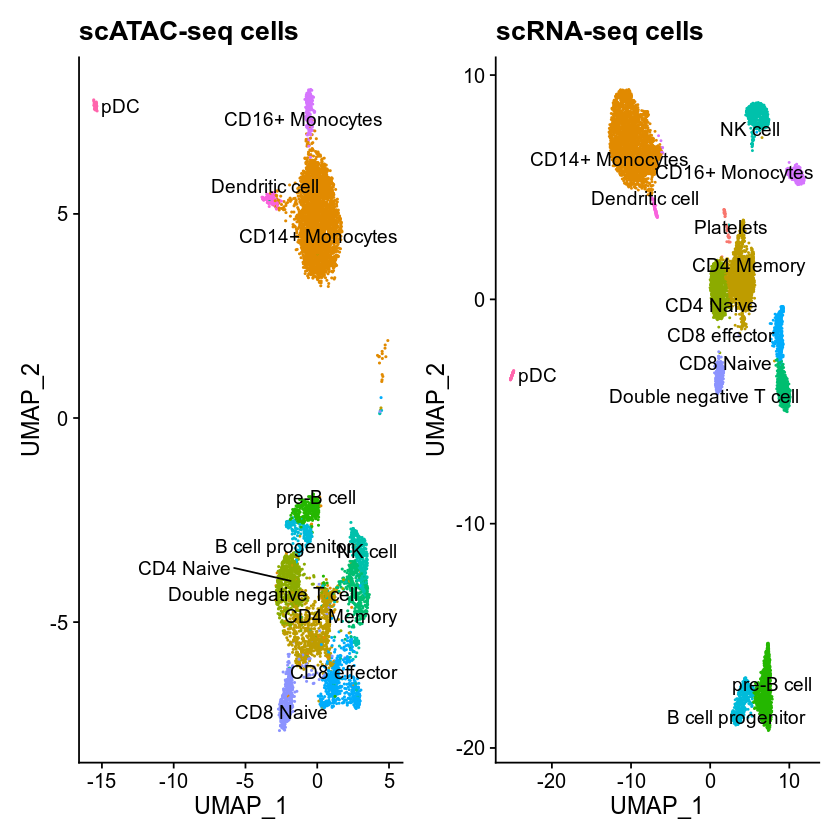

In [11]:
pbmc.atac.filtered <- subset(pbmc.atac, subset = prediction.score.max > 0.5)
pbmc.atac.filtered$predicted.id <- factor(pbmc.atac.filtered$predicted.id, levels = levels(pbmc.rna))  # to make the colors match
p1 <- DimPlot(pbmc.atac.filtered, group.by = "predicted.id", label = TRUE, repel = TRUE) + ggtitle("scATAC-seq cells") + 
    NoLegend() + scale_colour_hue(drop = FALSE)
p2 <- DimPlot(pbmc.rna, group.by = "celltype", label = TRUE, repel = TRUE) + ggtitle("scRNA-seq cells") + 
    NoLegend()
p1 + p2

In [12]:
# note that we restrict the imputation to variable genes from scRNA-seq, but could impute the
# full transcriptome if we wanted to
genes.use <- VariableFeatures(pbmc.rna)
refdata <- GetAssayData(pbmc.rna, assay = "RNA", slot = "data")[genes.use, ]

# refdata (input) contains a scRNA-seq expression matrix for the scRNA-seq cells.  imputation
# (output) will contain an imputed scRNA-seq matrix for each of the ATAC cells
imputation <- TransferData(anchorset = transfer.anchors, refdata = refdata, weight.reduction = pbmc.atac[["lsi"]])

# this line adds the imputed data matrix to the pbmc.atac object
pbmc.atac[["RNA"]] <- imputation
coembed <- merge(x = pbmc.rna, y = pbmc.atac)

# Finally, we run PCA and UMAP on this combined object, to visualize the co-embedding of both
# datasets
coembed <- ScaleData(coembed, features = genes.use, do.scale = FALSE)
coembed <- RunPCA(coembed, features = genes.use, verbose = FALSE)
coembed <- RunUMAP(coembed, dims = 1:30, n.components = 3)
coembed$celltype <- ifelse(!is.na(coembed$celltype), coembed$celltype, coembed$predicted.id)

Finding integration vectors

Finding integration vector weights

Transfering 3000 features onto reference data

Centering data matrix

01:43:07 UMAP embedding parameters a = 0.9922 b = 1.112

01:43:07 Read 17298 rows and found 30 numeric columns

01:43:07 Using Annoy for neighbor search, n_neighbors = 30

01:43:07 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

01:43:10 Writing NN index file to temp file /tmp/Rtmp3Pu1WT/file1deb568aece9

01:43:10 Searching Annoy index using 1 thread, search_k = 3000

01:43:15 Annoy recall = 100%

01:43:17 Commencing smooth kNN distance calibration using 1 thread

01:43:19 Found 2 connected components, falling back to 'spca' initialization with init_sdev = 1

01:43:19 Initializing from PCA

01:43:19 PCA: 3 components explained 84.81% v

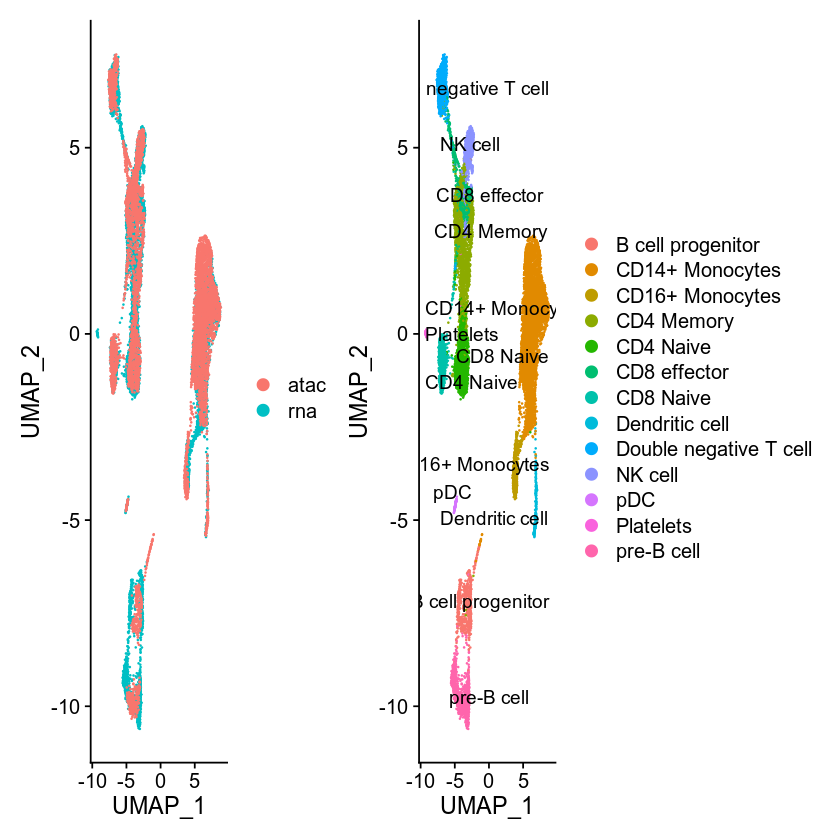

In [13]:
p1 <- DimPlot(coembed, group.by = "tech")
p2 <- DimPlot(coembed, group.by = "celltype", label = TRUE, repel = TRUE)
p1 + p2

In [17]:
devtools::install_github(repo = "mojaveazure/loomR", ref = "develop")

Registered S3 method overwritten by 'cli':
  method     from    
  print.boxx spatstat




bit   (1.1-15.2 -> 4.0.4) [CRAN]
bit64 (0.9-7    -> 4.0.2) [CRAN]


Installing 2 packages: bit, bit64

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



✔  checking for file ‘/tmp/Rtmp3Pu1WT/remotes1deb689b7171/mojaveazure-loomR-1eca16a/DESCRIPTION’ (948ms)
─  preparing ‘loomR’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘loomR_0.2.1.9000.tar.gz’
   


In [22]:
install.packages("reticulate")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [23]:
library(reticulate)

In [ ]:
as.loom

In [24]:
pbmc_ad <- Convert(from = coembed, to = "anndata", filename = "seurat_10xpbmc_coembed.h5ad")

ERROR: Error in Convert(from = coembed, to = "anndata", filename = "seurat_10xpbmc_coembed.h5ad"): could not find function "Convert"


In [25]:
coembed.loom <- as.loom(coembed, filename = "./seurat_10xpbmc_coembed2.loom", verbose = FALSE)

Transposing input data: loom file will show input columns (cells) as rows and input rows (features) as columns

This is to maintain compatibility with other loom tools

Adding: CellID

Adding: Gene



ERROR: Error in attributes[[i]]: subscript out of bounds


In [26]:
coembed.loom$close_all()

ERROR: Error in eval(expr, envir, enclos): object 'coembed.loom' not found


In [27]:
saveRDS(coembed, "./pbmc_10k_v3_coemb.rds")

In [28]:
pbmc.rna

An object of class Seurat 
19089 features across 9432 samples within 1 assay 
Active assay: RNA (19089 features, 3000 variable features)
 3 dimensional reductions calculated: pca, tsne, umap

In [30]:
pbmc.atac.filtered

An object of class Seurat 
108765 features across 7573 samples within 2 assays 
Active assay: ATAC (89796 features, 77033 variable features)
 1 other assay present: ACTIVITY
 2 dimensional reductions calculated: lsi, umap

In [34]:
pbmc.rna$observed

rna_AAACCCAAGCGCCCAT-1 rna_AAACCCACAGAGTTGG-1 rna_AAACCCACAGGTATGG-1 
           0.035812672            0.019227034            0.005447865 
rna_AAACCCACATAGTCAC-1 rna_AAACCCACATCCAATG-1 rna_AAACCCAGTGGCTACC-1 
           0.014276003            0.053857351            0.056603774 
rna_AAACCCATCTGTTCAT-1 rna_AAACGAAAGACGACGT-1 rna_AAACGAAAGACGTCGA-1 
           0.006448217            0.004519360            0.019607843 
rna_AAACGAAAGGAGTCTG-1 rna_AAACGAACAAGAATGT-1 rna_AAACGAACACGACGTC-1 
           0.059561129            0.017086166            0.056603774 
rna_AAACGAAGTTATGTCG-1 rna_AAACGAATCTACTTCA-1 rna_AAACGCTAGAGGTTTA-1 
           0.027975344            0.026876738            0.030958973 
rna_AAACGCTAGCACCAGA-1 rna_AAACGCTAGGCAGGTT-1 rna_AAACGCTAGGTTAAAC-1 
           0.035812672            0.076267172            0.066213922 
rna_AAACGCTAGTATGAAC-1 rna_AAACGCTCACGCAAAG-1 rna_AAACGCTCAGTCTTCC-1 
           0.042618901            0.021627188            0.091909741 
rna_AAACGCTCATAGTCAC-1 rna_AAACGCTGTCAGACGA-1 rna_AAACGCTGTCGATTTG-1 
           0.046679816            0.043587331            0.039881832 
rna_AAACGCTGTCTACATG-1 rna_AAAGAACAGTTCCGTA-1 rna_AAAGAACGTATCCTCC-1 
           0.025319292            0.095022624            0.016100179 
rna_AAAGAACGTATTCCGA-1 rna_AAAGAACGTCTCGGGT-1 rna_AAAGAACGTTTGTTGG-1 
           0.009113265            0.008102822            0.015164720 
rna_AAAGAACTCCTCCACA-1 rna_AAAGAACTCGCGTGCA-1 rna_AAAGAACTCTCATAGG-1 
           0.033624570            0.009537784            0.026876738 
rna_AAAGGATAGCAGTAAT-1 rna_AAAGGATAGTGAATAC-1 rna_AAAGGATGTCGGTGAA-1 
           0.030958973            0.048913043            0.022939677 
rna_AAAGGATGTGTCCAAT-1 rna_AAAGGATGTGTGGTCC-1 rna_AAAGGATTCAAGGACG-1 
           0.047778149            0.066213922            0.017426770 
rna_AAAGGATTCATTGTTC-1 rna_AAAGGATTCCTAACAG-1 rna_AAAGGATTCGTAACAC-1 
           0.048913043            0.026876738            0.017086166 
rna_AAAGGATTCTGCGGGT-1 rna_AAAGGATTCTTTGCAT-1 rna_AAAGGGCAGGGACCAT-1 
           0.032258065            0.035063876            0.012889542 
rna_AAAGGGCAGTTCCGGC-1 rna_AAAGGGCCACGTCGTG-1 rna_AAAGGGCCAGGTTCGC-1 
           0.020795477            0.015164720            0.005938549 
rna_AAAGGGCGTTACGTAC-1 rna_AAAGGGCTCATTTGGG-1 rna_AAAGGGCTCCAACTGA-1 
           0.006106275            0.029126214            0.028544015 
rna_AAAGGGCTCCTGGGAC-1 rna_AAAGGGCTCTCAAAGC-1 rna_AAAGGGCTCTTCCACG-1 
           0.061126648            0.064449064            0.046679816 
rna_AAAGGTAAGGGTCACA-1 rna_AAAGGTACAAGAATGT-1 rna_AAAGGTACAGCTACAT-1 
           0.022939677            0.033624570            0.027975344 
rna_AAAGGTAGTATTTCTC-1 rna_AAAGGTAGTCTACACA-1 rna_AAAGGTAGTGCTATTG-1 
           0.017426770            0.068053749            0.069973428 
rna_AAAGGTAGTTAAGGAT-1 rna_AAAGGTAGTTGTCATG-1 rna_AAAGTCCAGACCAAGC-1 
           0.015782940            0.074074074            0.098312973 
rna_AAAGTCCAGCAGGCTA-1 rna_AAAGTCCAGTCACACT-1 rna_AAAGTCCCAAGCTGTT-1 
           0.076267172            0.026876738            0.020795477 
rna_AAAGTCCCAAGTGGTG-1 rna_AAAGTCCGTCGAAACG-1 rna_AAAGTCCGTTCCCACT-1 
           0.047778149            0.043587331            0.078564500 
rna_AAAGTCCGTTCGGTTA-1 rna_AAAGTCCTCAACTACG-1 rna_AAAGTCCTCCAAGGGA-1 
           0.017773620            0.045616305            0.091909741 
rna_AAAGTCCTCTGGGTCG-1 rna_AAAGTGAAGAGTGGCT-1 rna_AAAGTGAAGCATGATA-1 
           0.066213922            0.022939677            0.035812672 
rna_AAAGTGAAGCGGGTAT-1 rna_AAAGTGAAGGTACATA-1 rna_AAAGTGACATAGGTTC-1 
           0.015164720            0.029722427            0.013157895 
rna_AAAGTGACATCGAACT-1 rna_AAAGTGACATGACGGA-1 rna_AAAGTGACATGCAGCC-1 
           0.074074074            0.006977992            0.002592133 
rna_AAAGTGAGTACCGTCG-1 rna_AAAGTGAGTTAAGACA-1 rna_AAAGTGATCGAAGTGG-1 
           0.017773620            0.029126214            0.013989550 
rna_AAAGTGATCGCGAAGA-1 rna_AAATGGAAGAGGGTAA-1 rna_AAATGGAAGCAAATGT-1 
          

In [35]:
genes.use

[1] "PPBP"        "PF4"         "IGLC3"       "GNLY"        "PTGDS"      
   [6] "CAVIN2"      "GNG11"       "JCHAIN"      "TUBB1"       "LYPD2"      
  [11] "IGKC"        "FCER1A"      "IGLC2"       "GZMB"        "FCGR3A"     
  [16] "GP9"         "S100A9"      "PTCRA"       "CCL4"        "CDKN1C"     
  [21] "S100A8"      "NRGN"        "TMEM40"      "LILRA4"      "ITM2C"      
  [26] "MEG3"        "HIST1H2AC"   "C1QA"        "ACRBP"       "CLU"        
  [31] "TYMS"        "NKG7"        "CLEC10A"     "LYZ"         "STMN1"      
  [36] "TSC22D1"     "IGHM"        "HLA-DPA1"    "PLD4"        "CMTM5"      
  [41] "CLEC1B"      "C1QB"        "CTTN"        "SCT"         "HLA-DRA"    
  [46] "HLA-DPB1"    "FGFBP2"      "EREG"        "HBG2"        "CLIC3"      
  [51] "S100A12"     "MYL9"        "TCL1A"       "TCF4"        "LMNA"       
  [56] "GZMH"        "CXCL8"       "HLA-DQA1"    "SPON2"       "ITGA2B"     
  [61] "KRT5"        "CD9"         "IRF7"        "CLDN5"       "CCL5"       
  [66] "MZB1"        "CCL3"        "GZMK"        "UGCG"        "TRDC"       
  [71] "TPM2"        "IFIT1"       "CCDC50"      "SERPINF1"    "G0S2"       
  [76] "S100B"       "TREML1"      "PRF1"        "KLRD1"       "HMOX1"      
  [81] "C2orf88"     "HLA-DRB1"    "CD1C"        "DNASE1L3"    "MYOM2"      
  [86] "IGHA2"       "IL3RA"       "DERL3"       "KLRB1"       "MKI67"      
  [91] "TK1"         "GZMA"        "FTL"         "IL1B"        "IRF8"       
  [96] "CD74"        "AC147651.1"  "IGHG1"       "IGHD"        "MS4A1"      
 [101] "ESAM"        "ENHO"        "HLA-DQB1"    "LINC00996"   "CD79A"      
 [106] "CST3"        "VCAN"        "SMIM25"      "PCLAF"       "LST1"       
 [111] "CLEC4C"      "KLRC1"       "SMPD3"       "TOP2A"       "NEAT1"      
 [116] "MS4A7"       "IGLC6"       "LAMP5"       "RAB27B"      "CXCL10"     
 [121] "GATA2"       "FTH1"        "FOS"         "C19orf33"    "PDZK1IP1"   
 [126] "PPP1R14B"    "APOBEC3A"    "IGHG3"       "RGS18"       "CXCL3"      
 [131] "IGHA1"       "KLRF1"       "AXL"         "IFIT2"       "FCN1"       
 [136] "IFIT3"       "MAP3K7CL"    "MPIG6B"      "CTSS"        "AIF1"       
 [141] "IFITM3"      "RRM2"        "SAT1"        "AC011498.1"  "PRKAR2B"    
 [146] "IFI44L"      "SPARC"       "EGFL7"       "CD8B"        "CST7"       
 [151] "AC090409.1"  "AQP10"       "LINC01781"   "MMD"         "PTGS2"      
 [156] "AP001189.1"  "IGLC7"       "ISG15"       "CTSW"        "C12orf75"   
 [161] "RETN"        "SMOX"        "IGHG2"       "LRRC26"      "TRBC1"      
 [166] "HOPX"        "HEMGN"       "TRGC2"       "MAFB"        "OLFM1"      
 [171] "CD14"        "SOX4"        "MNDA"        "IFI30"       "MARCKS"     
 [176] "LGALSL"      "CKB"         "XCL2"        "PTX3"        "LGALS1"     
 [181] "TCF7L2"      "IL7R"        "CD79B"       "BIRC5"       "CRYM"       
 [186] "RHOC"        "LGALS2"      "PSAP"        "SPIB"        "HES4"       
 [191] "SGK1"        "CD160"       "BANK1"       "HIST1H2BJ"   "CPVL"       
 [196] "CA2"         "FCER1G"      "PLBD1"       "DUSP1"       "TRBV14"     
 [201] "PDGFA"       "CYTL1"       "RRAD"        "TYMP"        "ODC1"       
 [206] "XCL1"        "IFI6"        "IL2RB"       "COTL1"       "PRSS57"     
 [211] "CPA3"        "MX1"         "VIM"         "MS4A6A"      "IL32"       
 [216] "AC007240.1"  "VMO1"        "HLA-DQA2"    "UBE2C"       "NPR3"       
 [221] "HLA-DRB5"    "CYP1B1"      "RHOB"        "S100A6"      "MRC1"       
 [226] "GMPR"        "RGS2"        "EMP1"        "PPP1R14A"    "TYROBP"     
 [231] "FOXP3"       "SCN9A"       "TNF"         "CXCL2"       "FCRL5"      
 [236] "ADGRG1"      "IFNG"        "LINC00926"   "HBA1"        "MAP1A"      
 [241] "GNAZ"        "MTURN"       "DUSP6"       "CD36"        "AL603756.1" 
 [246] "TRGC1"       "CEBPD"       "BCL11A"      "MYLK"        "ANKRD9"     
 [251] "HPGDS"       "RTKN2"       "CLSPN"       "SMIM5"       "SCAMP5"     
 [256] "RHEX"        "GP1BA"       "FGL2"        "ACTB"        "IGHG4"      

In [ ]:
pbmc.rna$

In [38]:
coembed$

ERROR: Error in eval(expr, envir, enclos): object 'coembed.atac' not found


In [42]:
coembed@graphs <- list()

In [51]:
coembed = FindVariableFeatures(coembed)

In [61]:
coembed$orig.ident = NULL

In [62]:
coembed.loom <- as.loom(coembed, filename = "./seurat_10xpbmc_coembed.loom", verbose = TRUE)

Transposing input data: loom file will show input columns (cells) as rows and input rows (features) as columns

This is to maintain compatibility with other loom tools



  |======================================================================| 100%


Adding: CellID

Adding: Gene

Adding a layer to norm_data (layer 1 of 1)



  |======================================================================| 100%


Adding: vst_mean

Adding: vst_variance

Adding: vst_variance_expected

Adding: vst_variance_standardized

Adding: vst_variable

Adding: Selected

Adding: nCount_RNA

Adding: nFeature_RNA

Adding: observed

Adding: simulated

Adding: percent_mito

Adding: RNA_snn_res_0_4

Adding: celltype

Adding: tech

Adding: nCount_ATAC

Adding: nFeature_ATAC

Adding: nCount_ACTIVITY

Adding: nFeature_ACTIVITY

Adding: total

Adding: duplicate

Adding: chimeric

Adding: unmapped

Adding: lowmapq

Adding: mitochondrial

Adding: passed_filters

Adding: cell_id

Adding: is__cell_barcode

Adding: TSS_fragments

Adding: DNase_sensitive_region_fragments

Adding: enhancer_region_fragments

Adding: promoter_region_fragments

Adding: on_target_fragments

Adding: blacklist_region_fragments

Adding: peak_region_fragments

Adding: predicted_id

Adding: prediction_score_CD4_Memory

Adding: prediction_score_CD14__Monocytes

Adding: prediction_score_NK_cell

Adding: prediction_score_pre_B_cell

Adding: prediction_s

  |======================================================================| 100%


Adding dimensional reduction information for pca

Adding cell embedding information for pca

Adding feature loading information for pca

Adding dimensional reduction information for umap

Adding cell embedding information for umap

No feature loading information for umap



In [63]:
coembed.loom$close_all()

In [ ]:
coembed@meta.data

In [55]:
for(j in 1:ncol(coembed@meta.data)){
	if(is.factor(coembed@meta.data[,j]) == T){
	coembed@meta.data[,j] = as.character(coembed@meta.data[,j]) # Force the variable type to be character
	coembed@meta.data[,j][is.na(coembed@meta.data[,j])] <- "N.A"
}
if(is.character(coembed@meta.data[,j]) == T){
	coembed@meta.data[,j][is.na(coembed@meta.data[,j])] <- "N.A"
 }
}

In [53]:
coembed$

An object of class Seurat 
127854 features across 17298 samples within 3 assays 
Active assay: RNA (19089 features, 2000 variable features)
 2 other assays present: ATAC, ACTIVITY
 2 dimensional reductions calculated: pca, umap

In [59]:
coembed$orig.ident = NONE

rna_AAACCCAAGCGCCCAT-1 rna_AAACCCACAGAGTTGG-1 rna_AAACCCACAGGTATGG-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAACCCACATAGTCAC-1 rna_AAACCCACATCCAATG-1 rna_AAACCCAGTGGCTACC-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAACCCATCTGTTCAT-1 rna_AAACGAAAGACGACGT-1 rna_AAACGAAAGACGTCGA-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAACGAAAGGAGTCTG-1 rna_AAACGAACAAGAATGT-1 rna_AAACGAACACGACGTC-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAACGAAGTTATGTCG-1 rna_AAACGAATCTACTTCA-1 rna_AAACGCTAGAGGTTTA-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAACGCTAGCACCAGA-1 rna_AAACGCTAGGCAGGTT-1 rna_AAACGCTAGGTTAAAC-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAACGCTAGTATGAAC-1 rna_AAACGCTCACGCAAAG-1 rna_AAACGCTCAGTCTTCC-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAACGCTCATAGTCAC-1 rna_AAACGCTGTCAGACGA-1 rna_AAACGCTGTCGATTTG-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAACGCTGTCTACATG-1 rna_AAAGAACAGTTCCGTA-1 rna_AAAGAACGTATCCTCC-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAAGAACGTATTCCGA-1 rna_AAAGAACGTCTCGGGT-1 rna_AAAGAACGTTTGTTGG-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAAGAACTCCTCCACA-1 rna_AAAGAACTCGCGTGCA-1 rna_AAAGAACTCTCATAGG-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAAGGATAGCAGTAAT-1 rna_AAAGGATAGTGAATAC-1 rna_AAAGGATGTCGGTGAA-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAAGGATGTGTCCAAT-1 rna_AAAGGATGTGTGGTCC-1 rna_AAAGGATTCAAGGACG-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAAGGATTCATTGTTC-1 rna_AAAGGATTCCTAACAG-1 rna_AAAGGATTCGTAACAC-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAAGGATTCTGCGGGT-1 rna_AAAGGATTCTTTGCAT-1 rna_AAAGGGCAGGGACCAT-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAAGGGCAGTTCCGGC-1 rna_AAAGGGCCACGTCGTG-1 rna_AAAGGGCCAGGTTCGC-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAAGGGCGTTACGTAC-1 rna_AAAGGGCTCATTTGGG-1 rna_AAAGGGCTCCAACTGA-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAAGGGCTCCTGGGAC-1 rna_AAAGGGCTCTCAAAGC-1 rna_AAAGGGCTCTTCCACG-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAAGGTAAGGGTCACA-1 rna_AAAGGTACAAGAATGT-1 rna_AAAGGTACAGCTACAT-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAAGGTAGTATTTCTC-1 rna_AAAGGTAGTCTACACA-1 rna_AAAGGTAGTGCTATTG-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAAGGTAGTTAAGGAT-1 rna_AAAGGTAGTTGTCATG-1 rna_AAAGTCCAGACCAAGC-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAAGTCCAGCAGGCTA-1 rna_AAAGTCCAGTCACACT-1 rna_AAAGTCCCAAGCTGTT-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAAGTCCCAAGTGGTG-1 rna_AAAGTCCGTCGAAACG-1 rna_AAAGTCCGTTCCCACT-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAAGTCCGTTCGGTTA-1 rna_AAAGTCCTCAACTACG-1 rna_AAAGTCCTCCAAGGGA-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAAGTCCTCTGGGTCG-1 rna_AAAGTGAAGAGTGGCT-1 rna_AAAGTGAAGCATGATA-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAAGTGAAGCGGGTAT-1 rna_AAAGTGAAGGTACATA-1 rna_AAAGTGACATAGGTTC-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAAGTGACATCGAACT-1 rna_AAAGTGACATGACGGA-1 rna_AAAGTGACATGCAGCC-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAAGTGAGTACCGTCG-1 rna_AAAGTGAGTTAAGACA-1 rna_AAAGTGATCGAAGTGG-1 
             "10x_RNA"              "10x_RNA"              "10x_RNA" 
rna_AAAGTGATCGCGAAGA-1 rna_AAATGGAAGAGGGTAA-1 rna_AAATGGAAGCAAATGT-1 
          

Depending on the desired annotations and genes to be visualized by the user, the following command can be executed to create *singlecellVR*-compatible .JSON object. 

`scvr -f ./seurat_10xpbmc_coembed.loom -t seurat -a ANNOTATIONS [-g GENES] [-o OUTPUT]`